# Plot results for each the B1AR PDB ligand example.

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../../')
from score.scores import ScoreContainer

mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

/Users/jpaggi/schrodinger.ve/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
path ='/Users/jpaggi/sherlock/oak/users/jpaggi/bpp_data'

prot = 'B1AR'
stats = 'stats41/stats'
scores = 'stats41/pdb/standard/1.0-mcss_contact_hbond_sb'
fname = 'pdb.sc'
struct = '2VT4'

root = '{}/{}/scores/{}'.format(path, prot, scores)
stats_root = '{}/{}/scores/{}'.format(path, prot, stats)
sc = ScoreContainer(root, stats_root, prot, struct)

cluster = sc.read_results(fname)
glide_cluster = {lig:0 for lig in cluster}

In [3]:
l_list = list(cluster.keys())
l_map = {lig: alpha for lig, alpha in zip(l_list, 'abcdefghijklm')}
l_list, l_map

(['2Y00_lig',
  '2Y02_lig',
  '2Y03_lig',
  '2Y04_lig',
  '2YCW_lig',
  '2YCZ_lig',
  '3ZPQ_lig',
  '3ZPR_lig',
  '4AMI_lig',
  '4AMJ_lig',
  '5A8E_lig'],
 {'2Y00_lig': 'a',
  '2Y02_lig': 'b',
  '2Y03_lig': 'c',
  '2Y04_lig': 'd',
  '2YCW_lig': 'e',
  '2YCZ_lig': 'f',
  '3ZPQ_lig': 'g',
  '3ZPR_lig': 'h',
  '4AMI_lig': 'i',
  '4AMJ_lig': 'j',
  '5A8E_lig': 'k'})

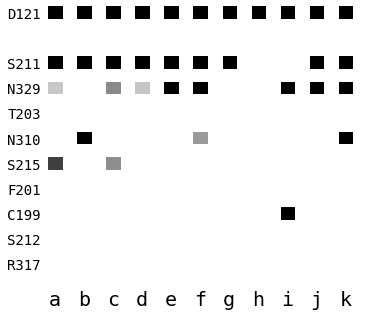

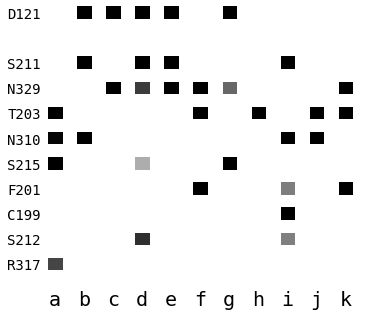

In [4]:
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from settings import feature_defs


def gel_plot_individual(self, cluster, lig_order, interactions=None,
                        divide=2, resname_size=14, ax=None, pretty=True):
    
    _X = self.interaction_matrix(cluster, interactions, lig_order)
    
    X, labels = [], []
    for i, (type1, res1) in enumerate(interactions):
        for (_, res2) in interactions[:i]:
            if res1 == res2:
                break
        else:
            X += [_X[i, :]]
            labels += [format_res(res1)]
            for j, (_, res2) in enumerate(interactions[i+1:]):
                j = j + i + 1
                if res1 == res2:
                    X[-1] += _X[j, :]
            
    X = np.vstack(X)

    # Y is X + empty cells seperating boxes.
    Y = np.zeros((X.shape[0]*divide, X.shape[1]*divide))
    
    Y[::divide, ::divide] = X
    
    if ax is None:
        figure = plt.figure(figsize =  (9, 4.5))
        gs = GridSpec(1, 2, figure = figure, width_ratios = [4, 5])
        ax = plt.subplot(gs[1])
    ax.imshow(Y, cmap='binary', aspect = 'auto', vmin=0, vmax=1.0)
    #ax.set(adjustable='box', aspect='equal')

    if pretty:
        self._pretty(lig_order, labels, divide, resname_size)
        
def format_res(interaction):
    three_to_one = {
        'TYR': 'Y',
        'VAL': 'V',
        'ARG': 'R',
        'THR': 'T',
        'GLU': 'E',
        'SER': 'S',
        'PHE': 'F',
        'ALA': 'A',
        'MET': 'M',
        'ILE': 'I',
        'ASP': 'D',
        'GLN': 'Q',
        'ASN': 'N',
        'GLY': 'G',
        'PRO': 'P',
        'TRP': 'W',
        'LEU': 'L',
        'LYS': 'K',
        'CYS': 'C',
        'HIS': 'H'
    }
    name = interaction.split('(')[1][:-1]
    num = interaction.split('(')[0].split(':')[1]
    if name in three_to_one:
        name = three_to_one[name]
    return '{}{}'.format(name, num)


interactions = sc.ps.interactions([cluster, glide_cluster],  'hbond')
unique, keys = [], set()
for code, res in interactions[::-1]:
    if res not in keys:
        unique += [(code, res)]
    keys.add(res)
    
interactions = interactions[:1] + [('', 'A: ( )')] + interactions[1:]

gel_plot_individual(sc.ps, cluster, l_list, interactions=interactions, resname_size = 14)
plt.xticks(range(0, 2*len(l_list), 2), [l_map[lig] for lig in l_list], rotation = 'horizontal', size = 20)
plt.tight_layout()
plt.savefig('../../pymol/figures/b1ar/panels/combind.pdf')
plt.show()

gel_plot_individual(sc.ps, glide_cluster, l_list, interactions=interactions, resname_size = 14)
plt.xticks(range(0, 2*len(l_list), 2), [l_map[lig] for lig in l_list], rotation = 'horizontal', size = 20)
plt.tight_layout()
plt.savefig('../../pymol/figures/b1ar/panels/glide.pdf')
plt.show()

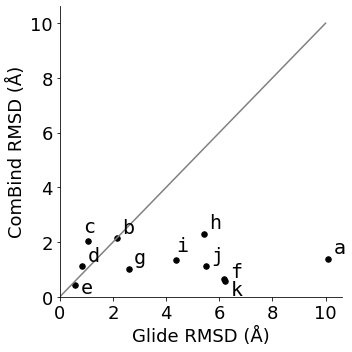

In [5]:
combind_rmsds = [sc.ps.get_rmsd({lig: cluster[lig]}) for lig in l_list]
glide_rmsds = [sc.ps.get_rmsd({lig: glide_cluster[lig]}) for lig in l_list]
f, ax = plt.subplots(figsize = (5, 5))
ax.scatter(glide_rmsds, combind_rmsds, s = 30, c = 'k')
ax.plot(range(11), c = 'grey')


for x, y, lig in zip(glide_rmsds, combind_rmsds, l_list):
    x_shift, y_shift = 0.2, 0.2
    if lig == '2YCW_lig':
        x_shift, y_shift = 0.2, -0.3
    if lig == '2Y03_lig':
        x_shift, y_shift = -0.2, 0.3
    if lig == '4AMI_lig':
        x_shift, y_shift = 0, 0.3
    if lig == '5A8E_lig':
        x_shift, y_shift = 0.2, -0.5
    if lig == '2YCZ_lig':
        x_shift, y_shift = 0.2, 0.05
        
    ax.text(x+x_shift, y+y_shift, l_map[lig], size = 20, name = 'monospace')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(0)
ax.set_ylim(ax.get_xlim())
ax.set_yticklabels(range(0, 11, 2), size=18)
ax.set_xticklabels(range(0, 11, 2), size=18)

ax.set_ylabel('ComBind RMSD (Å)', size = 18)
ax.set_xlabel('Glide RMSD (Å)', size = 18)
plt.tight_layout()
plt.savefig('../../pymol/figures/b1ar/panels/performance.pdf')
plt.show()

In [6]:
path ='/Users/jpaggi/sherlock/oak/users/jpaggi/bpp_data'

prot = 'B1AR'
stats = 'stats41/stats'
scores = 'stats41/pdb/all_crystal'
fname = 'pdb.sc'
struct = '2VT4'

root = '{}/{}/scores/{}'.format(path, prot, scores)
stats_root = '{}/{}/scores/{}'.format(path, prot, stats)
sc = ScoreContainer(root, stats_root, prot, struct, crystal=True)

cluster = sc.read_results(fname)
glide_cluster = {lig:0 for lig in cluster}

l_list = list(cluster.keys())
l_map = {lig: alpha for lig, alpha in zip(l_list, 'abcdefghijklm')}
l_list, l_map

(['2Y00_crystal_lig',
  '2Y02_crystal_lig',
  '2Y03_crystal_lig',
  '2Y04_crystal_lig',
  '2YCW_crystal_lig',
  '2YCZ_crystal_lig',
  '3ZPQ_crystal_lig',
  '3ZPR_crystal_lig',
  '4AMI_crystal_lig',
  '4AMJ_crystal_lig',
  '5A8E_crystal_lig'],
 {'2Y00_crystal_lig': 'a',
  '2Y02_crystal_lig': 'b',
  '2Y03_crystal_lig': 'c',
  '2Y04_crystal_lig': 'd',
  '2YCW_crystal_lig': 'e',
  '2YCZ_crystal_lig': 'f',
  '3ZPQ_crystal_lig': 'g',
  '3ZPR_crystal_lig': 'h',
  '4AMI_crystal_lig': 'i',
  '4AMJ_crystal_lig': 'j',
  '5A8E_crystal_lig': 'k'})

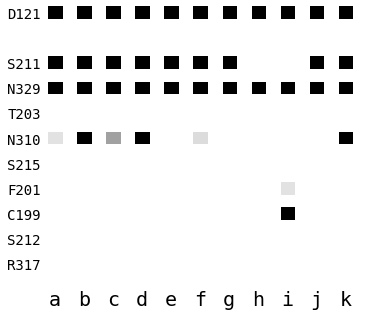

In [7]:
gel_plot_individual(sc.ps, glide_cluster, l_list, interactions=interactions, resname_size = 14)
plt.xticks(range(0, 2*len(l_list), 2), [l_map[lig] for lig in l_list], rotation = 'horizontal', size = 20)
plt.tight_layout()
plt.savefig('../../pymol/figures/b1ar/panels/xtal.pdf')
plt.show()